# Structural similarity

In previous two exercises, we have characterized chemical structures using binary vectors representing their features: either directly (structural keys such as MACCS) or in a hashed form (hashed fingerprints such as ECFP). Aside from narrowing down substructure searches or searching for specific fragments, these binary feature vectors can be used to quantify structural similarity. This is based on the premise that structures with similar feature vectors have to be structurally similar themselves. This may sound a bit sketchy, but as you will see, it works pretty well, especially with hashed fingerprints such as ECFP.

This gets us to the question of how to measure similarity of binary vectors. Luckily, this is already a pretty generic question that has been extensively worked upon long before cheminformatics was a thing. Probably the simplest, and definitely the most often used one in cheminformatics is the [Tanimoto similarity](https://en.wikipedia.org/wiki/Jaccard_index) aka the Jaccard index. Tanimoto similarity coefficient is measure of how many features do the two compared feature vectors have in common, compared to how many features they have overall. This means that feature vectors that share all features, i.e. are completely identical, will have Tanimoto coefficient 1. Feature vectors that share no features at all have Tanimoto coefficient of 0, and any other cases will be somewhere between these two limit values. Much more info is on the wiki artice, no point in copypasting :) Other measures such as [Manhattan distance](https://en.wikipedia.org/wiki/Taxicab_geometry) or [Dice coefficient](https://en.wikipedia.org/wiki/Dice%27s_coefficient) are also often implemented in cheminformatic toolkits, ready to be used for some edge cases. Quite a few are described in the [Daylight documentation](https://www.daylight.com/dayhtml/doc/theory/theory.finger.html), Section 6.3. However, Tanimoto is pretty much the vanilla of binary vector comparisons. Let's implement it: 

# What to do:
 - Familiarize yourself with similarity between feature vectors (mainly Tanimoto), though you probably know it already :)
 - Implement for yourself a function that measures Tanimoto similarity between two binary vectors, and try it out.
 - Do a similarity search of your ligands within the DrugBank database using using hashed fingerprints (ECFP). Are any of your ligands significantly structurally similar to any DrugBank compounds? How many?
 - Do you think that some substances similar to your known ligands were already considered or even applied for therapeutic purposes?
 - Implement for yourself a function that measures Tanimoto dissimilarity for the purposes of diversity picking.
 - Perform diversity picking on your ligand set, i.e. use the diversity picker to select a small representative subset of mutually dissimilar structures that cover as much of the chemical diversity of your ligand set as possible. Pick at least 20 representative structures, or around 1% of your ligand set size, whichever one is greater. Visualize the picked structures.
 - Does each next picked structure differ considerably from the previously picked ones, or is the subset limited to only few structural motifs? What would the latter mean?

In [1]:
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
import csv

RDKit WARNING: [11:21:46] Enabling RDKit 2019.09.3 jupyter extensions


### let's define the Tanimoto similarity for ourselves:


In [2]:
# let's define the Tanimoto similarity for ourselves:

def tanimoto(vector1, vector2):
    set_bits = 0
    shared_bits = 0
    for bit1, bit2 in zip(vector1, vector2):
        if bit1 or bit2: # at least one vector has this feature
            set_bits += 1
            if bit1 and bit2: # both vectors have this feature
                shared_bits += 1
    return shared_bits / set_bits

# and check our implementation on several vectors
print(tanimoto([1, 1, 0, 0], [0, 0, 1, 1])) # share nothing
print(tanimoto([0, 1, 1, 0], [1, 0, 1, 0])) # share bit of 3
print(tanimoto([1, 1, 1, 1], [0, 0, 1, 1])) # share 2 bits of 4
print(tanimoto([1, 1, 1, 1], [0, 1, 1, 1])) # share 3 bits of 4
print(tanimoto([1, 1, 0, 0], [1, 1, 0, 0])) # share 2 bits of 2

0.0
0.3333333333333333
0.5
0.75
1.0


This implementation seems ok for our little 4-bit vectors. 

### Let's try it on some actual fingerprint vectors :)

In [3]:
# load your own set, and DrugBank :)
with open('DRD1_without_PAINS.txt', mode='r', encoding='utf-8') as txtfile:
    drd1_ligands = [Chem.MolFromSmiles(line) for line in txtfile]

suppl = Chem.SDMolSupplier('../data/drugbank.sdf')
drugs = [m for m in suppl if m]

**DRD1**

This gene encodes the D1 subtype of the dopamine receptor. The D1 subtype is the most abundant dopamine receptor in the central nervous system. This G-protein coupled receptor stimulates adenylyl cyclase and activates cyclic AMP-dependent protein kinases. D1 receptors regulate neuronal growth and development, mediate some behavioral responses, and modulate dopamine receptor D2-mediated events. Alternate transcription initiation sites result in two transcript variants of this gene.

In [4]:
from rdkit.Chem import MACCSkeys
fp1 = MACCSkeys.GenMACCSKeys(drugs[1])
fp2 = MACCSkeys.GenMACCSKeys(drugs[30])
print(fp1.ToBitString())
print(fp2.ToBitString())

00000000000000000000000001000000000001000001000000001110000000000110110000110111101111000111101111001100111001111101111111101111110110001111111101111111111111111111110
00000000000000100000000000000000000000000000000000000010000000000001000000000000000010001010000100000000100000010000000000011000010100001011101000100001011111110100100


In [5]:
tanimoto(fp1, fp2)

0.28735632183908044

So, our ghetto tanimoto similarity implementation work on the MACCS keys too. Luckily, we do not have to implement similarity metrics ourselves - many are [already implemented in RDKit](https://www.rdkit.org/docs/source/rdkit.DataStructs.cDataStructs.html): 

In [6]:
from rdkit import DataStructs

In [7]:
DataStructs.TanimotoSimilarity(fp1, fp2) # same result as our own implementation :)

0.28735632183908044

Now that we have our Tanimoto similarity tried and tested for both artificial small vector and also on some actual fingerprints, let's calculate MACCS keys for all our ligands and all our known drugs. 

### Then, we can try a basic similarity search:

In [8]:
drd1_ligands_maccs = [MACCSkeys.GenMACCSKeys(m) for m in drd1_ligands]
drugs_maccs = [MACCSkeys.GenMACCSKeys(m) for m in drugs]

Let's implement a basic similarity search function. We will take a single binary vector as a query, compare it to all binary vectors in the provided searched set. If its the Tanimoto similarity of the query vector to any of the searched fingerprints reaches or exceed our set cutoff value (0.8 is usually where some noticeable similarity starts to happen when using standard ECFP types), the index of the found similar vector is appended to the results.

In [9]:
def similarity_search(query_fp, searched_fp_set, cutoff=0.8):
    # we have no index, so we will have to just iterate through the entire searched set
    hits = []
    for i, fp in enumerate(searched_fp_set):
        similarity = DataStructs.TanimotoSimilarity(query_fp, fp)
        if similarity >= cutoff: # similar enough for consideration
            hits.append((i, similarity))
    return sorted(hits, key=lambda x: x[1], reverse=True) # stronger hits first

This is, in a very simplified fashon, exactly what the large, often commercial chemical databases do when users perform a similarity search. Their input structure gets fingerprinted, the resulting fingerprint compared to those in the database, and molecules with similar fingerprints are returned as hits. Of course, they do extended indexing and heuristics to make the searches quicker, alongside some hit reordering and sanitation, but the core principle is the same: create query fingerprint, compare with database fingerprints using some similarity metric, return hits above threshold. Same sh.t, different toilet :)

### similarity search method to search of aspirin in drugs

In [10]:
# let's use our similarity search method to search of aspirin in drugs.
# There should be some hits :)
aspirin = Chem.MolFromSmiles('O=C(C)Oc1ccccc1C(=O)O')
aspirin_fp = MACCSkeys.GenMACCSKeys(aspirin)
hits = similarity_search(aspirin_fp, drugs_maccs)
display(hits)

[(825, 1.0),
 (1214, 0.8333333333333334),
 (6457, 0.8333333333333334),
 (6629, 0.8076923076923077),
 (6413, 0.8)]

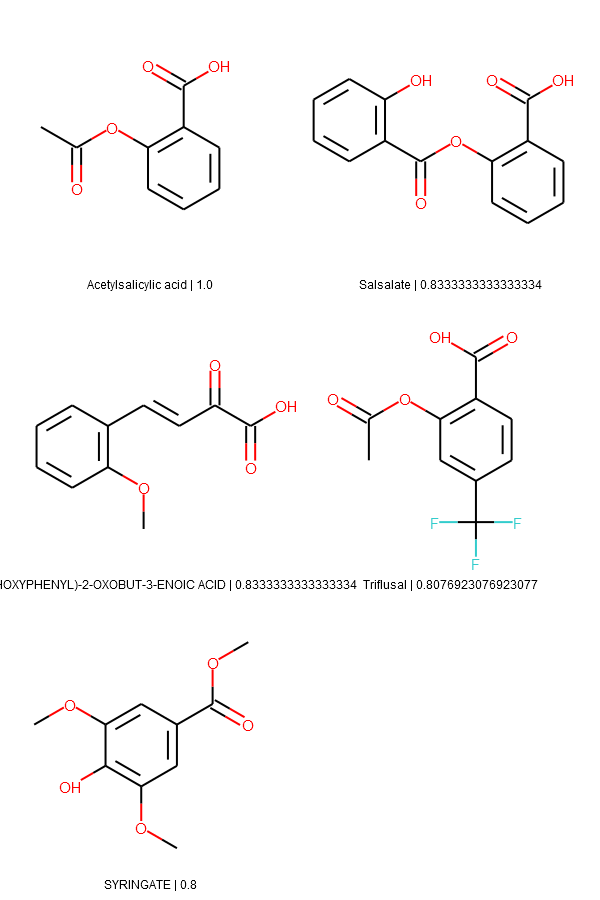

In [11]:
Draw.MolsToGridImage([drugs[hit[0]] for hit in hits],
                     molsPerRow=2, subImgSize=(300,300),
                     legends=["{} | {}".format(drugs[hit[0]].GetProp('GENERIC_NAME'), hit[1]) for hit in hits])

We found acetylsalicylic acid (i.e. Aspirin) as an exact match (tanimoto 1.0), and four other apparently quite similar structures. Seems that our similarity search is working :) 

### let's try to look up some molecule from our ligand set within DrugBank:

#### First DRD1 ligand

In [12]:
hits_first = similarity_search(drd1_ligands_maccs[0], drugs_maccs)
hits_first

[(598, 0.8333333333333334)]

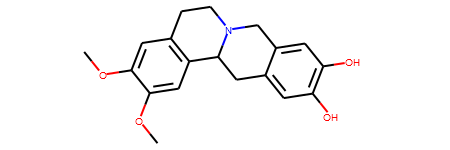

In [13]:
drd1_ligands[0]  # my query structure

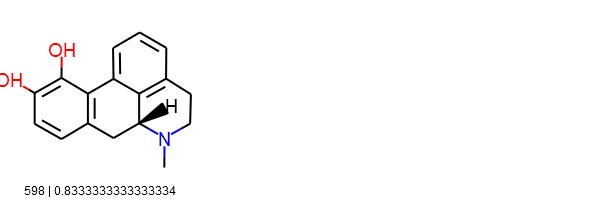

In [14]:
# the hits among Drugbank using MACCS keys
Draw.MolsToGridImage([drugs[hit[0]] for hit in hits_first], legends=["{} | {}".format(hit[0], hit[1]) for hit in hits_first])

So, our first drd1 ligand hit one DrugBank structure at the lower rung of our similarity threshold (0.83). If we look closely, there is a similarity in number of rings, also one could find somewhat similar substructure with three rings, involving N atom and two OH groups.

#### Third DRD1 ligand

In [15]:
hits_third = similarity_search(drd1_ligands_maccs[2], drugs_maccs)
hits_third

[(1073, 1.0),
 (1775, 1.0),
 (6585, 0.851063829787234),
 (2974, 0.813953488372093)]

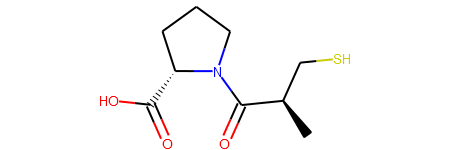

In [16]:
drd1_ligands[2]  # my query structure

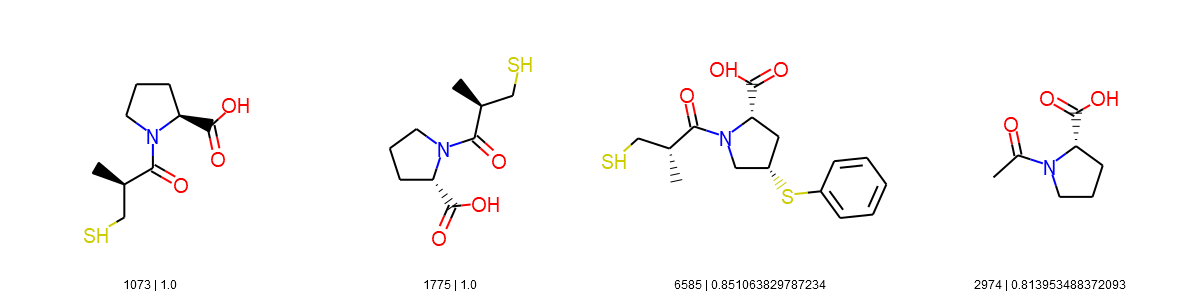

In [17]:
# the hits among Drugbank using MACCS keys
Draw.MolsToGridImage([drugs[hit[0]] for hit in hits_third], legends=["{} | {}".format(hit[0], hit[1]) for hit in hits_third],  molsPerRow=4, subImgSize=(300,300))

Third drd1 ligand hit four DrugBank structures. Two at the lower rung of our similarity threshold (0.85, 0.81). However, the other two got similarity equal to one (seem to conformers).

### Let's do the same exact query, but using ECFP instead of MACCS:

In [18]:
drd1_ligands_ecfp = [Chem.GetMorganFingerprintAsBitVect(m, 2, nBits=1024)
                     for m in drd1_ligands]
drugs_ecfp = [Chem.GetMorganFingerprintAsBitVect(m, 2, nBits=1024)
              for m in drugs]

In [19]:
# first ligand
hits_0 = similarity_search(drd1_ligands_ecfp[0], drugs_ecfp)
hits_0

[]

In [20]:
# third ligand
hits_2 = similarity_search(drd1_ligands_ecfp[2], drugs_ecfp)
hits_2

[(1073, 1.0), (1775, 1.0)]

No similarity hits for first ligand using ECFP. There is some for the third one. 
### Let's see what the ECFP-based similarity with the two previous MACCS-based hits is:

#### First DRD1 ligand

In [21]:
DataStructs.TanimotoSimilarity(drd1_ligands_ecfp[0], drugs_ecfp[598])

0.288135593220339

#### Third DRD1 ligand

In [22]:
ligand_index = 2
hit_numbers = [hit[0] for hit in hits_third]
for hit_number in hit_numbers:
    similarity = DataStructs.TanimotoSimilarity(drd1_ligands_ecfp[ligand_index], drugs_ecfp[hit_number])
    print(hit_number, ":", similarity)

1073 : 1.0
1775 : 1.0
6585 : 0.46
2974 : 0.5428571428571428


Same query molecule, same similarity measurement, but a different feature vector type yielded very different results. The two structures hit by the similarity search based on the MACCS keys (over 0.8 Tanimoto similarity) have much lower similarity values when using ECFP. This is because MACCS and ECFP are quite different in what structural features they cover. When using fingerprint-based similarity search, it is always good idea to think a bit about what structural features do the used fingerprints represent, and therefore what is used as the basis for structural similarity. **It is also a good idea to include information about the exact used feature vector type (e.g. MACCS, ECFP6-1024 bit, ECFP4-512 bit, etc.) and the exact used similarity measurement method (e.g. Tanimoto, Manhattan) whenever you present any similarity search results.**

### Let's search for all our ligands among the DrugBank database, to see how close we are to the known drugs:

In [23]:
drd1_ligands_queries = [(i, similarity_search(ligand_ecfp, drugs_ecfp))
                     for i, ligand_ecfp in enumerate(drd1_ligands_ecfp)]
drd1_ligands_queries

[(0, []),
 (1, []),
 (2, [(1073, 1.0), (1775, 1.0)]),
 (3, [(7027, 1.0)]),
 (4, [(364, 1.0)]),
 (5, []),
 (6, []),
 (7, []),
 (8, [(1663, 1.0), (3547, 1.0)]),
 (9, []),
 (10, [(1019, 1.0)]),
 (11, []),
 (12, [(4071, 1.0)]),
 (13, []),
 (14, [(801, 1.0)]),
 (15, []),
 (16, [(1093, 1.0)]),
 (17, [(848, 1.0)]),
 (18, []),
 (19, []),
 (20, []),
 (21, [(719, 1.0)]),
 (22, [(895, 1.0)]),
 (23, [(515, 1.0), (7097, 0.8636363636363636)]),
 (24, []),
 (25, [(1156, 1.0)]),
 (26, [(540, 1.0)]),
 (27, []),
 (28, [(4286, 1.0)]),
 (29, [(536, 1.0)]),
 (30, [(6777, 1.0)]),
 (31, [(779, 1.0)]),
 (32, [(1069, 1.0)]),
 (33, [(214, 1.0)]),
 (34, [(928, 1.0), (6927, 1.0)]),
 (35, [(228, 1.0)]),
 (36, [(1013, 1.0), (1041, 1.0), (2678, 1.0)]),
 (37, [(358, 1.0)]),
 (38, [(1079, 1.0)]),
 (39, [(1024, 1.0)]),
 (40, [(3497, 1.0)]),
 (41, [(45, 1.0)]),
 (42, [(232, 1.0)]),
 (43, []),
 (44, [(6835, 1.0)]),
 (45, [(171, 1.0)]),
 (46, []),
 (47, []),
 (48, []),
 (49, []),
 (50, [(1608, 1.0)]),
 (51, [(739, 1.0)]),


For every ligand, we have a list of drugs that match their structural features (ECFP4, 1024bit) at Tanimoto similarity of 0.8 and higher. SOme queries come up empty at this similarity threshold of 0.8, but there are some actual hits:

In [24]:
# only take ligands that actually matched something in DrugBank
drd1_ligand_hits = [hit for hit in drd1_ligands_queries if hit[1]]
drd1_ligand_hits

[(2, [(1073, 1.0), (1775, 1.0)]),
 (3, [(7027, 1.0)]),
 (4, [(364, 1.0)]),
 (8, [(1663, 1.0), (3547, 1.0)]),
 (10, [(1019, 1.0)]),
 (12, [(4071, 1.0)]),
 (14, [(801, 1.0)]),
 (16, [(1093, 1.0)]),
 (17, [(848, 1.0)]),
 (21, [(719, 1.0)]),
 (22, [(895, 1.0)]),
 (23, [(515, 1.0), (7097, 0.8636363636363636)]),
 (25, [(1156, 1.0)]),
 (26, [(540, 1.0)]),
 (28, [(4286, 1.0)]),
 (29, [(536, 1.0)]),
 (30, [(6777, 1.0)]),
 (31, [(779, 1.0)]),
 (32, [(1069, 1.0)]),
 (33, [(214, 1.0)]),
 (34, [(928, 1.0), (6927, 1.0)]),
 (35, [(228, 1.0)]),
 (36, [(1013, 1.0), (1041, 1.0), (2678, 1.0)]),
 (37, [(358, 1.0)]),
 (38, [(1079, 1.0)]),
 (39, [(1024, 1.0)]),
 (40, [(3497, 1.0)]),
 (41, [(45, 1.0)]),
 (42, [(232, 1.0)]),
 (44, [(6835, 1.0)]),
 (45, [(171, 1.0)]),
 (50, [(1608, 1.0)]),
 (51, [(739, 1.0)]),
 (52, [(920, 1.0)]),
 (53, [(328, 1.0)]),
 (54, [(996, 1.0)]),
 (55, [(362, 1.0)]),
 (57, [(6916, 1.0)]),
 (59, [(664, 1.0)]),
 (61, [(3358, 1.0)]),
 (62, [(399, 1.0)]),
 (63, [(784, 1.0)]),
 (64, [(1049

In [25]:
len(drd1_ligands_queries), len(drd1_ligand_hits)

(1018, 614)

Here, 614 of 1018 (more than a half!) ligands appear to be significantly structurally similar to something in DrugBank. Let's have a look at one of the ligand hits:

(2, [(1073, 1.0), (1775, 1.0)])


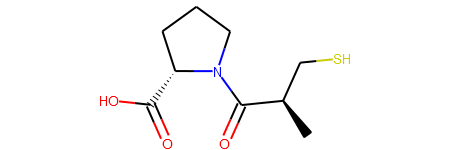

In [26]:
print(drd1_ligand_hits[0])
# The query structure
display(drd1_ligands[drd1_ligand_hits[0][0]])

In the above, the drd1 ligand 2 hits DrugBank structure 1073 and 1775 fully by Tanimoto similarity over ECFP4 fingerprints.

(3, [(7027, 1.0)])


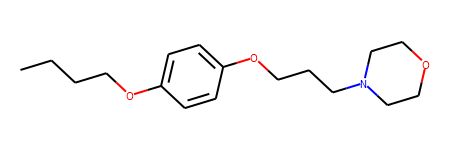

In [27]:
print(drd1_ligand_hits[1])
# The query structure
display(drd1_ligands[drd1_ligand_hits[1][0]])

In the above, the drd1 ligand 3 hits DrugBank structure 7027 fully by Tanimoto similarity over ECFP4 fingerprints.

### Let's see what it hits:

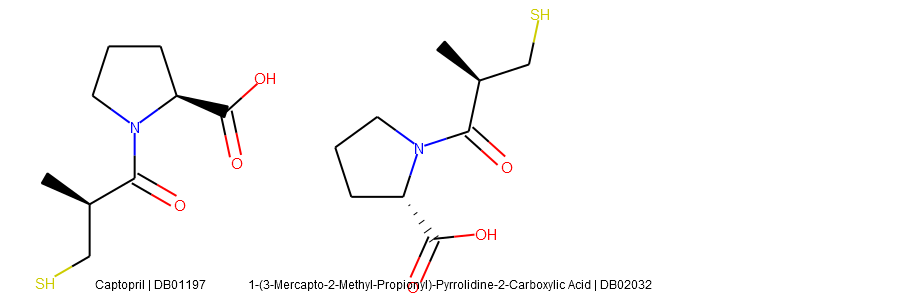

In [28]:
# And the DrugBank hits to that
hit_mols = [drugs[index] for index, similarity in drd1_ligand_hits[0][1]]
Draw.MolsToGridImage(hit_mols, molsPerRow=3, subImgSize=(300,300),
                     legends=["{} | {}".format(m.GetProp('GENERIC_NAME'), m.GetProp('DRUGBANK_ID'))
                              for m in hit_mols])

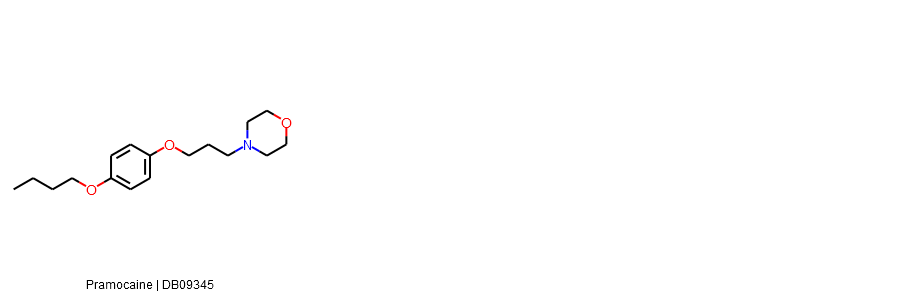

In [29]:
hit_mols = [drugs[index] for index, similarity in drd1_ligand_hits[1][1]]
Draw.MolsToGridImage(hit_mols, molsPerRow=3, subImgSize=(300,300),
                     legends=["{} | {}".format(m.GetProp('GENERIC_NAME'), m.GetProp('DRUGBANK_ID'))
                              for m in hit_mols])

The hits in DrugBank look similar to the ligands. The full match of our drd1 ligand 2 is Captopril https://go.drugbank.com/drugs/DB01197. Inhibitor of angiotensin-converting enzyme.

The match of our ligand 3 is Pramocaine https://go.drugbank.com/drugs/DB09345. Pramocaine reversibly binds and inhibits voltage gated sodium channels on neurons decreasing sodium permeability into the cell

Neither of these two seems to be a known DRD1 ligand.

Those are two hits from a single query structure. 

### Let's have a look at all the DrugBank hits from all query drd1 ligands:

In [30]:
drugs_hitcounts = {}
for ligand, hits in drd1_ligand_hits:
    for hit, similarity in hits:
        drugs_hitcounts[hit] = drugs_hitcounts.get(hit, 0) + 1
len(drugs_hitcounts), sorted(drugs_hitcounts.items(), key=lambda item: item[1], reverse=True)

(687,
 [(456, 4),
  (2939, 4),
  (90, 4),
  (928, 3),
  (6927, 3),
  (330, 3),
  (1109, 3),
  (505, 3),
  (455, 3),
  (919, 3),
  (1663, 2),
  (3547, 2),
  (1013, 2),
  (1041, 2),
  (2678, 2),
  (3497, 2),
  (289, 2),
  (991, 2),
  (302, 2),
  (937, 2),
  (453, 2),
  (4310, 2),
  (279, 2),
  (508, 2),
  (714, 2),
  (840, 2),
  (925, 2),
  (476, 2),
  (1066, 2),
  (1411, 2),
  (566, 2),
  (732, 2),
  (320, 2),
  (426, 2),
  (923, 2),
  (1077, 2),
  (1076, 2),
  (408, 2),
  (639, 2),
  (861, 2),
  (242, 2),
  (1128, 2),
  (389, 2),
  (1518, 2),
  (888, 2),
  (6928, 2),
  (98, 2),
  (210, 2),
  (187, 2),
  (881, 2),
  (186, 2),
  (489, 2),
  (218, 2),
  (231, 2),
  (830, 2),
  (1087, 2),
  (1212, 2),
  (278, 2),
  (199, 2),
  (1073, 1),
  (1775, 1),
  (7027, 1),
  (364, 1),
  (1019, 1),
  (4071, 1),
  (801, 1),
  (1093, 1),
  (848, 1),
  (719, 1),
  (895, 1),
  (515, 1),
  (7097, 1),
  (1156, 1),
  (540, 1),
  (4286, 1),
  (536, 1),
  (6777, 1),
  (779, 1),
  (1069, 1),
  (214, 1),
  (228

In [31]:
ordered_drugs_hitcounts = sorted(drugs_hitcounts.keys(), key=lambda x: drugs_hitcounts[x], reverse=True)
len(ordered_drugs_hitcounts), ordered_drugs_hitcounts

(687,
 [456,
  2939,
  90,
  928,
  6927,
  330,
  1109,
  505,
  455,
  919,
  1663,
  3547,
  1013,
  1041,
  2678,
  3497,
  289,
  991,
  302,
  937,
  453,
  4310,
  279,
  508,
  714,
  840,
  925,
  476,
  1066,
  1411,
  566,
  732,
  320,
  426,
  923,
  1077,
  1076,
  408,
  639,
  861,
  242,
  1128,
  389,
  1518,
  888,
  6928,
  98,
  210,
  187,
  881,
  186,
  489,
  218,
  231,
  830,
  1087,
  1212,
  278,
  199,
  1073,
  1775,
  7027,
  364,
  1019,
  4071,
  801,
  1093,
  848,
  719,
  895,
  515,
  7097,
  1156,
  540,
  4286,
  536,
  6777,
  779,
  1069,
  214,
  228,
  358,
  1079,
  1024,
  45,
  232,
  6835,
  171,
  1608,
  739,
  920,
  328,
  996,
  362,
  6916,
  664,
  3358,
  399,
  784,
  1049,
  841,
  377,
  224,
  4861,
  6838,
  1116,
  1239,
  997,
  4644,
  1027,
  173,
  387,
  640,
  662,
  397,
  4368,
  4027,
  3654,
  854,
  625,
  6824,
  1104,
  1381,
  963,
  1097,
  570,
  66,
  3351,
  946,
  819,
  4287,
  438,
  1100,
  849,
  697,


C:\Users\elieb\miniconda3\envs\cdd\lib\site-packages\rdkit\Chem\Draw\IPythonConsole.py:188: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  % (maxMols))


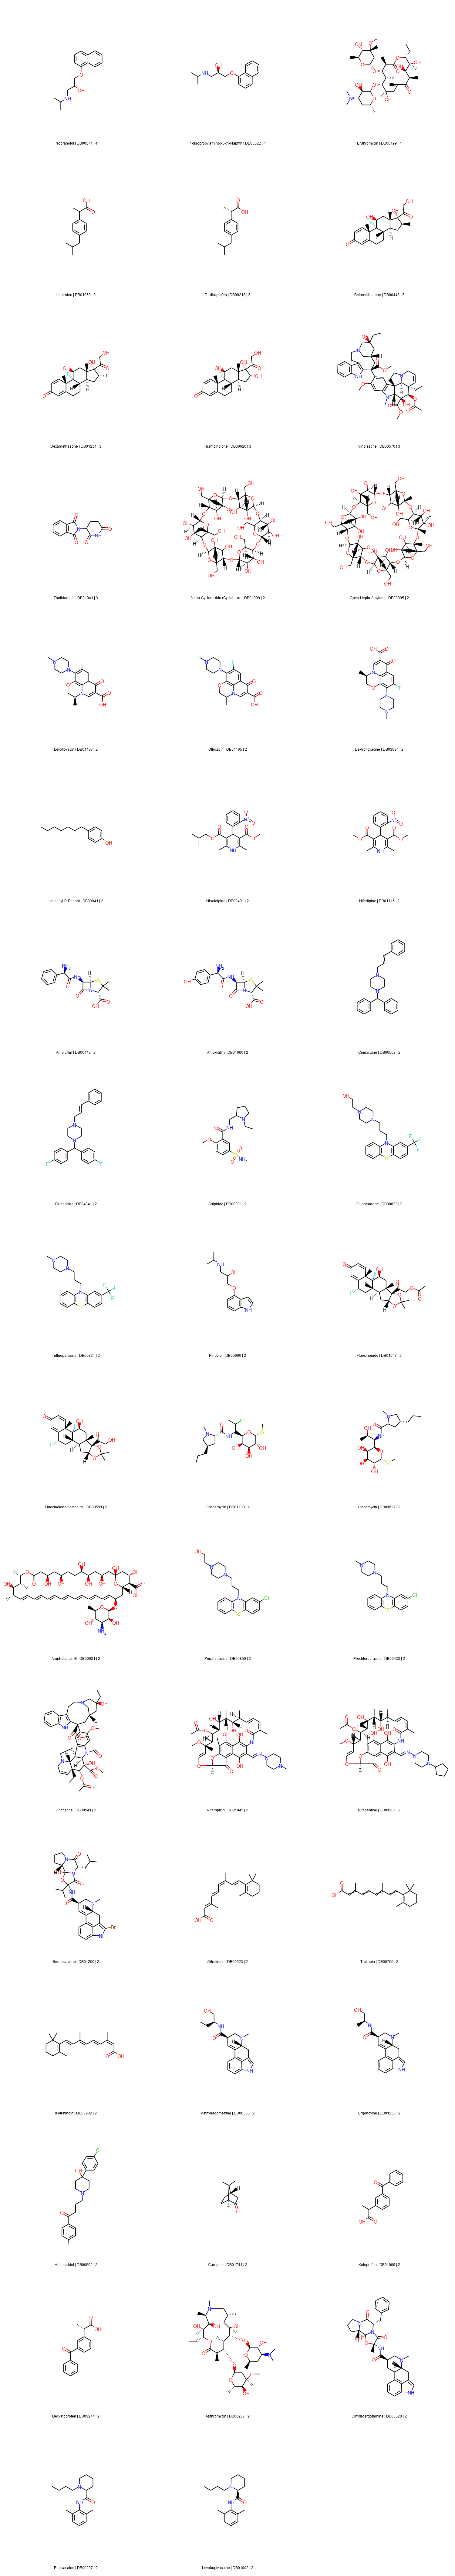

In [32]:
hit_mols = [drugs[i] for i in ordered_drugs_hitcounts]
Draw.MolsToGridImage(hit_mols, molsPerRow=3, subImgSize=(500,500),
                     legends=["{} | {} | {}".format(drugs[i].GetProp('GENERIC_NAME')[:30], # just cut off too long IUPAC stuff
                                                    drugs[i].GetProp('DRUGBANK_ID'),
                                                    drugs_hitcounts[i])
                              for i in ordered_drugs_hitcounts])

When queried for known mtor ligands using ECFP4-1024, the most frequently hit substances in the DrugBank database are Propanolol, Dexpropranolol and Erythromycin with 4 independent hits. None of them seem to have anything to do with DRD1 https://go.drugbank.com/bio_entities/BE0000020 according to Drugbank search.

The Ibuprofen, Dexibuprofen, Betamethasone, Dexamethasone, Triamcinolone, Vinblastine, Thalidomide hit by 3 known drd1 ligands each. None of them have DRD1 as a target.

There is a lot of structures in DRD1 dataset which hit drugbank twice. However, not all have been plotted above (why?). There is so many. I did not check all for being connected to DRD1 target.

## Finding known drug in hits

None of the above listed drugs are connected to DRD1, so i tried to search for known DRD1 related drugs in the drugbank dataset:

Of all ligands https://go.drugbank.com/bio_entities/BE0000020 I randomly chose Methylergometrine (drugbank ID: DB00353) https://go.drugbank.com/drugs/DB00353



DB00353
Methylergometrine


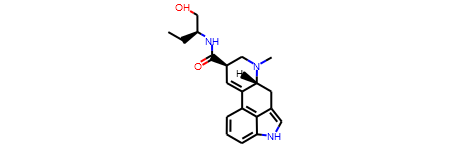

In [133]:
# is in drugbank dataset? (should be :))
Methylergometrine = ""
Methylergometrine_ID = "DB00353"
for i in drugs:
    if i.GetProp('DRUGBANK_ID') == Methylergometrine_ID:
        print(i.GetProp('DRUGBANK_ID'))
        print(i.GetProp('GENERIC_NAME'))
        display(i)
        Methylergometrine = i

In [55]:
# is in 
Methylergometrine in hit_mols

True

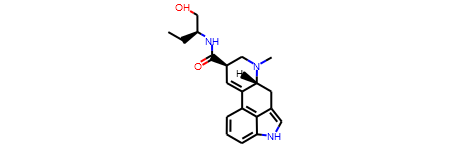

DB00353
Methylergometrine
hit in drd1_ligand_hits (322, [(242, 1.0), (1128, 0.8064516129032258)])


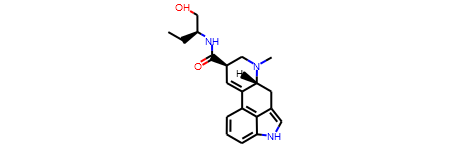

DB00353
Methylergometrine
hit in drd1_ligand_hits (736, [(1128, 1.0), (242, 0.8064516129032258)])


In [134]:
for i, hit in enumerate(drd1_ligand_hits):
    for j, drug in enumerate(drd1_ligand_hits[i][1]):
        if drugs[drug[0]].GetProp('DRUGBANK_ID') == Methylergometrine_ID:
            display(drugs[drug[0]])
            print(drugs[drug[0]].GetProp('DRUGBANK_ID'))
            print(drugs[drug[0]].GetProp('GENERIC_NAME'))
            print("hit in drd1_ligand_hits", hit)

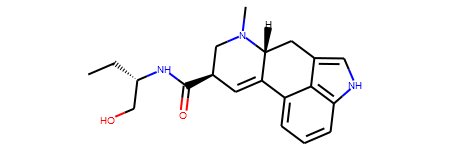

In [139]:
drd1_Methylergometrine = drd1_ligands[322]
drd1_Methylergometrine

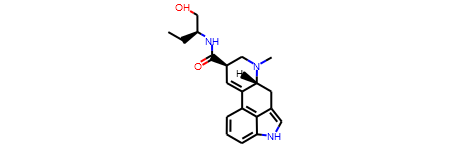

In [137]:
Methylergometrine

In [62]:
Methylergometrine in drd1_ligands

False

In [140]:
drd1_Methylergometrine == Methylergometrine 

False

Well, ... I don't quite understand why the Methylergometrine in drd1_ligands cannot be found easily, but it is there :)))

# Diversity picking

Finding molecules that are structurally similar to our query is very useful, and indeed very often used, but it is not the only way to practically utilize the concept of structural similarity. Sometimes, the problem is very different. Often, there is a scenario where we have a large set of candidate structures, and limited time/resources/money/facilities to model/prepare/buy/test them. A computationally expensive model that can realistically process only a fraction of all your virtual compounds. A limited budget to buy substances. A grumpy and already overworked synthetic chemist. You get the idea :)

In those cases, you want to prioritize those structures of your set that have the potential to be most useful. This is usually done by using faster, less resource-intensive computational approaches. However, other things being equal, you also want to preserve the chemical diversity in your set of candidate structures. Testing 1000th variant of the same basic structure can be a waste of time in early stages of screening, chemists will do plenty of that in later stages of lead development, for the very best candidates.

In screening, it is often advantageous to sample a large set of structures in a way that covers as much of the set's chemical diversity in as few chemical structures as possible. Structural diversity is often defined an inverse of their structural similarity. Let's implement such an inverse of Tanimoto similarity, a "structural distance" of sorts:

In [33]:
def distance_function(index1, index2, *args, fingerprints=drd1_ligands_ecfp,
                      metric=DataStructs.TanimotoSimilarity):
    return 1 - DataStructs.FingerprintSimilarity(fingerprints[index1],
                                                 fingerprints[index2],
                                                 metric=metric)

Using this distance function, we can pick structures from our set so that we pick the first structure at random, the second structure as the one most distant from the first, the third structure would be the one most distant from the previous two, the fourth one the most distant from the previous three, etc. etc., until we have our diverse representative subset of chosen size. However, this distance recomputing can be quite expensive, especially for larger substance set. For few thousand structures maybe, but try a billion and despair. There are however some implementations that employ heuristics to make this selection process much faster. They are not guaranteed to provide absolutely optimal coverage, but their near-optimal solutions are perfectly fine in practice and much faster to compute. RDKit implements such pickers, most notably the MaxMin picker [described nicely here](https://rdkit.blogspot.com/2017/11/revisting-maxminpicker.html). Let's use it on our ligand set, and grab about 1%-sized diverse subset based on distance between their ECFP vectors:

In [34]:
 len(drd1_ligands)/100 # 1 % sample

10.18

In [35]:
from rdkit.SimDivFilters.rdSimDivPickers import MaxMinPicker
picker = MaxMinPicker()
picked = list(picker.LazyPick(distance_function, len(drd1_ligands), 10))
picked

[567, 15, 230, 344, 962, 135, 308, 532, 650, 548]

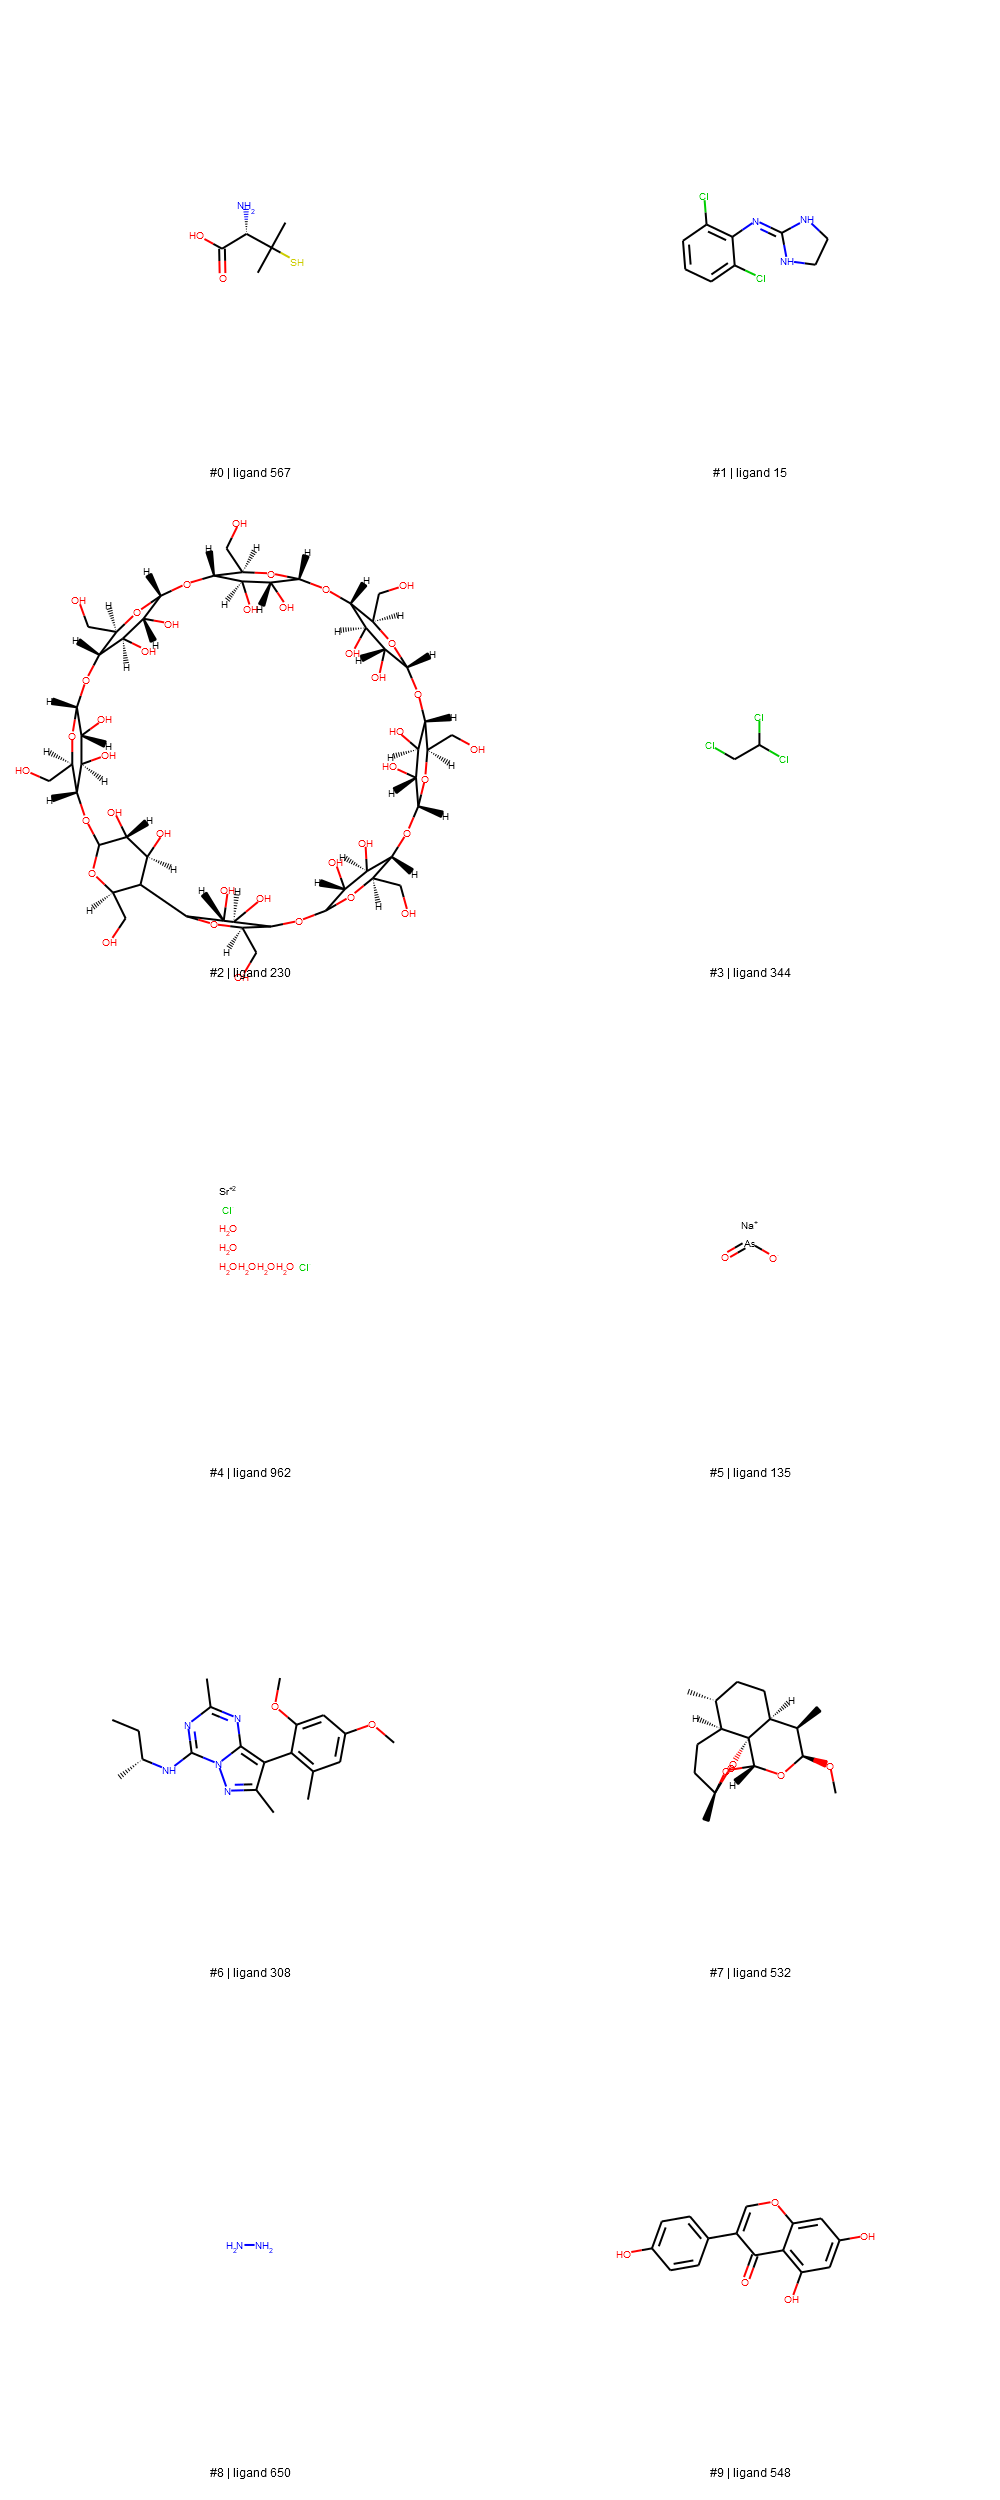

In [36]:
Draw.MolsToGridImage([drd1_ligands[i] for i in picked], molsPerRow=2, subImgSize=(500,500),
                     legends=["#{} | ligand {}".format(i, hit) for i, hit in enumerate(picked)])

That looks quite diverse :) Small molecules, big molecules with rings, even some inorganic compounds (#1,#3). This demonstrates the picker's ability to cover large amount of the set's chemical diversity in a relatively small amount of structures.

If you find yourself with limited resources to process all the compounds in your set, or if you just want a good test subset of your main course, some form of diversity picking is definitely a thing to consider.